In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from datetime import date, datetime
import time
import calendar
path = '/Users/atanughosh/Documents/SJSU/257/Project/'

In [ ]:
#Reading the train and test dataset and the supplimentary dataset

In [23]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

oil = pd.read_csv(path + 'oil.csv')
holiday = pd.read_csv(path + 'holidays_events.csv')
store = pd.read_csv(path + 'stores.csv')
tran = pd.read_csv(path + 'transactions.csv')

In [ ]:
#Getting details of the data

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [25]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [26]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [27]:
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [28]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [29]:
tran.info()
tran.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [30]:
#Data preprocessing
def preprocess_train(df):
    df['date'] = df['date'].map(lambda x: date.fromisoformat(x))
    df['weekday'] = df['date'].map(lambda x: x.weekday())
    df['year'] = df['date'].map(lambda x: x.year)
    df['month'] = df['date'].map(lambda x: x.month)
    df['day'] = df['date'].map(lambda x: x.day)
    df['eomd'] = df['date'].map(lambda x: calendar.monthrange(x.year, x.month)[1])
    df['payday'] = ((df['day'] == df['eomd'])|(df['day'] == 15)).astype(int)
    df = df.drop(['id', 'eomd'], axis=1)
    return df

train = preprocess_train(train)
test = preprocess_train(test)

In [31]:
test

,date,store_nbr,family,onpromotion,weekday,year,month,day,payday
0,2017-08-16,1,AUTOMOTIVE,0,2,2017,8,16,0
1,2017-08-16,1,BABY CARE,0,2,2017,8,16,0
2,2017-08-16,1,BEAUTY,2,2,2017,8,16,0
3,2017-08-16,1,BEVERAGES,20,2,2017,8,16,0
4,2017-08-16,1,BOOKS,0,2,2017,8,16,0
...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,POULTRY,1,3,2017,8,31,1
28508,2017-08-31,9,PREPARED FOODS,0,3,2017,8,31,1
28509,2017-08-31,9,PRODUCE,1,3,2017,8,31,1
28510,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,3,2017,8,31,1


In [32]:
def preprocess_oil(oil):
    oil['month'] = oil['date'].map(lambda x: int(x.replace('-', '')[:6]))
    oil['month_avg'] = oil.groupby('month')['dcoilwtico'].transform('mean')
    oil['tmp'] = oil['dcoilwtico'].map(np.isnan)
    oil['month_avg'] = oil['tmp'] * oil['month_avg']
    oil['dcoilwtico'].fillna(0, inplace=True)
    oil['dcoilwtico'] = oil['dcoilwtico'] + oil['month_avg']
    oil = oil.drop(['month', 'month_avg', 'tmp'], axis=1)
    oil['date'] = oil['date'].map(lambda x: date.fromisoformat(x))
    return oil

oil = preprocess_oil(oil)

In [33]:
oil

,date,dcoilwtico
0,2013-01-01,94.756667
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-07,93.200000
...,...,...
1213,2017-08-25,47.650000
1214,2017-08-28,46.400000
1215,2017-08-29,46.460000
1216,2017-08-30,45.960000


In [34]:
def preprocess_holiday(df):
    df['date'] = df['date'].map(lambda x: date.fromisoformat(x))
    df = df[(df['transferred']==False)&(df['type']!='Work Day')]
    event = df[df['type']=='Event']
    earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
    event = event[event['description'].str.startswith('Terremoto Manabi')==False]
    return df, event, earthquake

holiday, event, earthquake = preprocess_holiday(holiday)

event = event[['date', 'description']]
event.rename({'description': 'event_name'}, axis=1, inplace=True)

earthquake = earthquake[['date', 'description']]
earthquake.rename({'description': 'earthquake'}, axis=1, inplace=True)

h_local = holiday[holiday['locale']=='Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name': 'city', 'description': 'local_holiday_name'}, axis=1)

h_regional = holiday[holiday['locale']=='Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name': 'state', 'description': 'regional_holiday_name'}, axis=1)

h_national = holiday[holiday['locale']=='National']
h_national = h_national[['date', 'description']]
h_national = h_national.rename({'description': 'national_holiday_name'}, axis=1)

In [35]:
holiday

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [36]:
def merge_tables(df):
    df = df.merge(oil, on='date', how='left')
    df = df.merge(store, on='store_nbr', how='left')
    df = df.merge(event, on='date', how='left').fillna('0')
    df = df.merge(earthquake, on='date', how='left').fillna('0')
    df = df.merge(h_local, on=['date', 'city'], how='left').fillna('0')
    df = df.merge(h_regional, on=['date', 'state'], how='left').fillna('0')
    df = df.merge(h_national, on='date', how='left').fillna('0')
    df = df.merge(tran, on=['date', 'store_nbr'], how='left').fillna(0)

    return df

train = merge_tables(train)
test = merge_tables(test)


In [37]:
train.shape


(3008280, 21)

In [38]:
test.shape

(28512, 20)

In [39]:
train['dcoilwtico'] = train['dcoilwtico'].astype(float)
test['dcoilwtico'] = test['dcoilwtico'].astype(float)

In [40]:
test

,date,store_nbr,family,onpromotion,weekday,year,month,day,payday,dcoilwtico,city,state,type,cluster,event_name,earthquake,local_holiday_name,regional_holiday_name,national_holiday_name,transactions
0,2017-08-16,1,AUTOMOTIVE,0,2,2017,8,16,0,46.80,Quito,Pichincha,D,13,0,0,0,0,0,0.0
1,2017-08-16,1,BABY CARE,0,2,2017,8,16,0,46.80,Quito,Pichincha,D,13,0,0,0,0,0,0.0
2,2017-08-16,1,BEAUTY,2,2,2017,8,16,0,46.80,Quito,Pichincha,D,13,0,0,0,0,0,0.0
3,2017-08-16,1,BEVERAGES,20,2,2017,8,16,0,46.80,Quito,Pichincha,D,13,0,0,0,0,0,0.0
4,2017-08-16,1,BOOKS,0,2,2017,8,16,0,46.80,Quito,Pichincha,D,13,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,POULTRY,1,3,2017,8,31,1,47.26,Quito,Pichincha,B,6,0,0,0,0,0,0.0
28508,2017-08-31,9,PREPARED FOODS,0,3,2017,8,31,1,47.26,Quito,Pichincha,B,6,0,0,0,0,0,0.0
28509,2017-08-31,9,PRODUCE,1,3,2017,8,31,1,47.26,Quito,Pichincha,B,6,0,0,0,0,0,0.0
28510,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,3,2017,8,31,1,47.26,Quito,Pichincha,B,6,0,0,0,0,0,0.0


In [41]:
train

,date,store_nbr,family,sales,onpromotion,weekday,year,month,day,payday,...,city,state,type,cluster,event_name,earthquake,local_holiday_name,regional_holiday_name,national_holiday_name,transactions
0,2013-01-01,1,AUTOMOTIVE,0.000,0,1,2013,1,1,0,...,Quito,Pichincha,D,13,0,0,0,0,Primer dia del ano,0.0
1,2013-01-01,1,BABY CARE,0.000,0,1,2013,1,1,0,...,Quito,Pichincha,D,13,0,0,0,0,Primer dia del ano,0.0
2,2013-01-01,1,BEAUTY,0.000,0,1,2013,1,1,0,...,Quito,Pichincha,D,13,0,0,0,0,Primer dia del ano,0.0
3,2013-01-01,1,BEVERAGES,0.000,0,1,2013,1,1,0,...,Quito,Pichincha,D,13,0,0,0,0,Primer dia del ano,0.0
4,2013-01-01,1,BOOKS,0.000,0,1,2013,1,1,0,...,Quito,Pichincha,D,13,0,0,0,0,Primer dia del ano,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008275,2017-08-15,9,POULTRY,438.133,0,1,2017,8,15,1,...,Quito,Pichincha,B,6,0,0,0,0,0,0.0
3008276,2017-08-15,9,PREPARED FOODS,154.553,1,1,2017,8,15,1,...,Quito,Pichincha,B,6,0,0,0,0,0,0.0
3008277,2017-08-15,9,PRODUCE,2419.729,148,1,2017,8,15,1,...,Quito,Pichincha,B,6,0,0,0,0,0,0.0
3008278,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,1,2017,8,15,1,...,Quito,Pichincha,B,6,0,0,0,0,0,0.0


<AxesSubplot:>

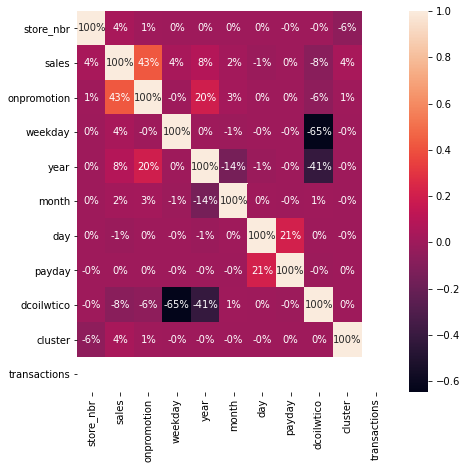

In [42]:
#Generating the heatmap for feature corelation analysis

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
plt.figure(figsize = (7,7))
sns.heatmap(train.corr(), annot=True, fmt='.0%')

<ipython-input-43-4bff1d795835>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correl, dtype = np.bool)


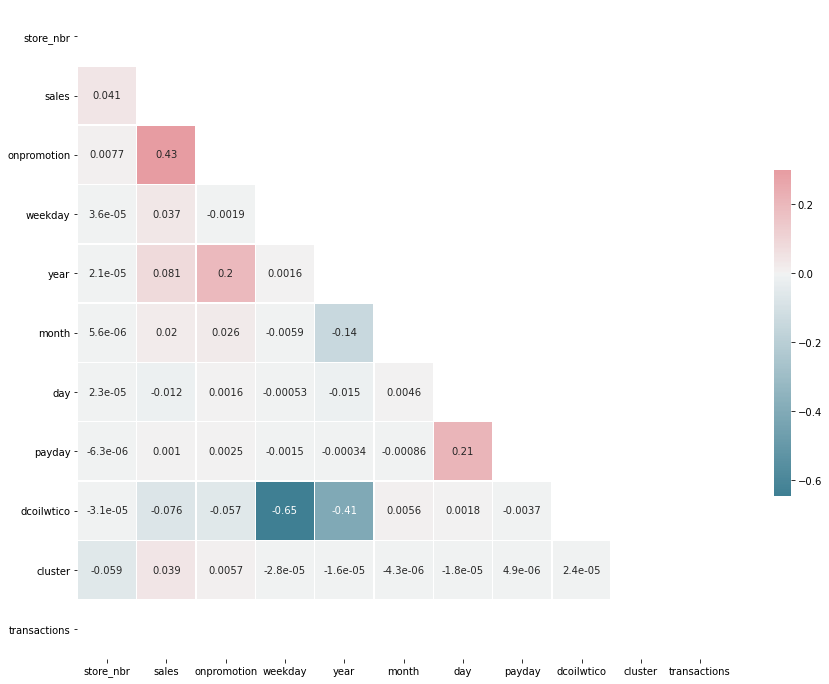

In [43]:
import seaborn as sb
correl = train.corr()
cmap = sb.diverging_palette(220, 10, as_cmap = True)

mask = np.zeros_like(correl, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (16, 12))

sb.heatmap(correl, mask = mask, cmap = cmap, vmax = 0.3, center = 0,annot = True, square = True, linewidths = 0.5, cbar_kws = {"shrink": .5});

In [44]:
train.isnull().sum()

date                     0
store_nbr                0
family                   0
sales                    0
onpromotion              0
weekday                  0
year                     0
month                    0
day                      0
payday                   0
dcoilwtico               0
city                     0
state                    0
type                     0
cluster                  0
event_name               0
earthquake               0
local_holiday_name       0
regional_holiday_name    0
national_holiday_name    0
transactions             0
dtype: int64

In [ ]:
#Plotting all the features

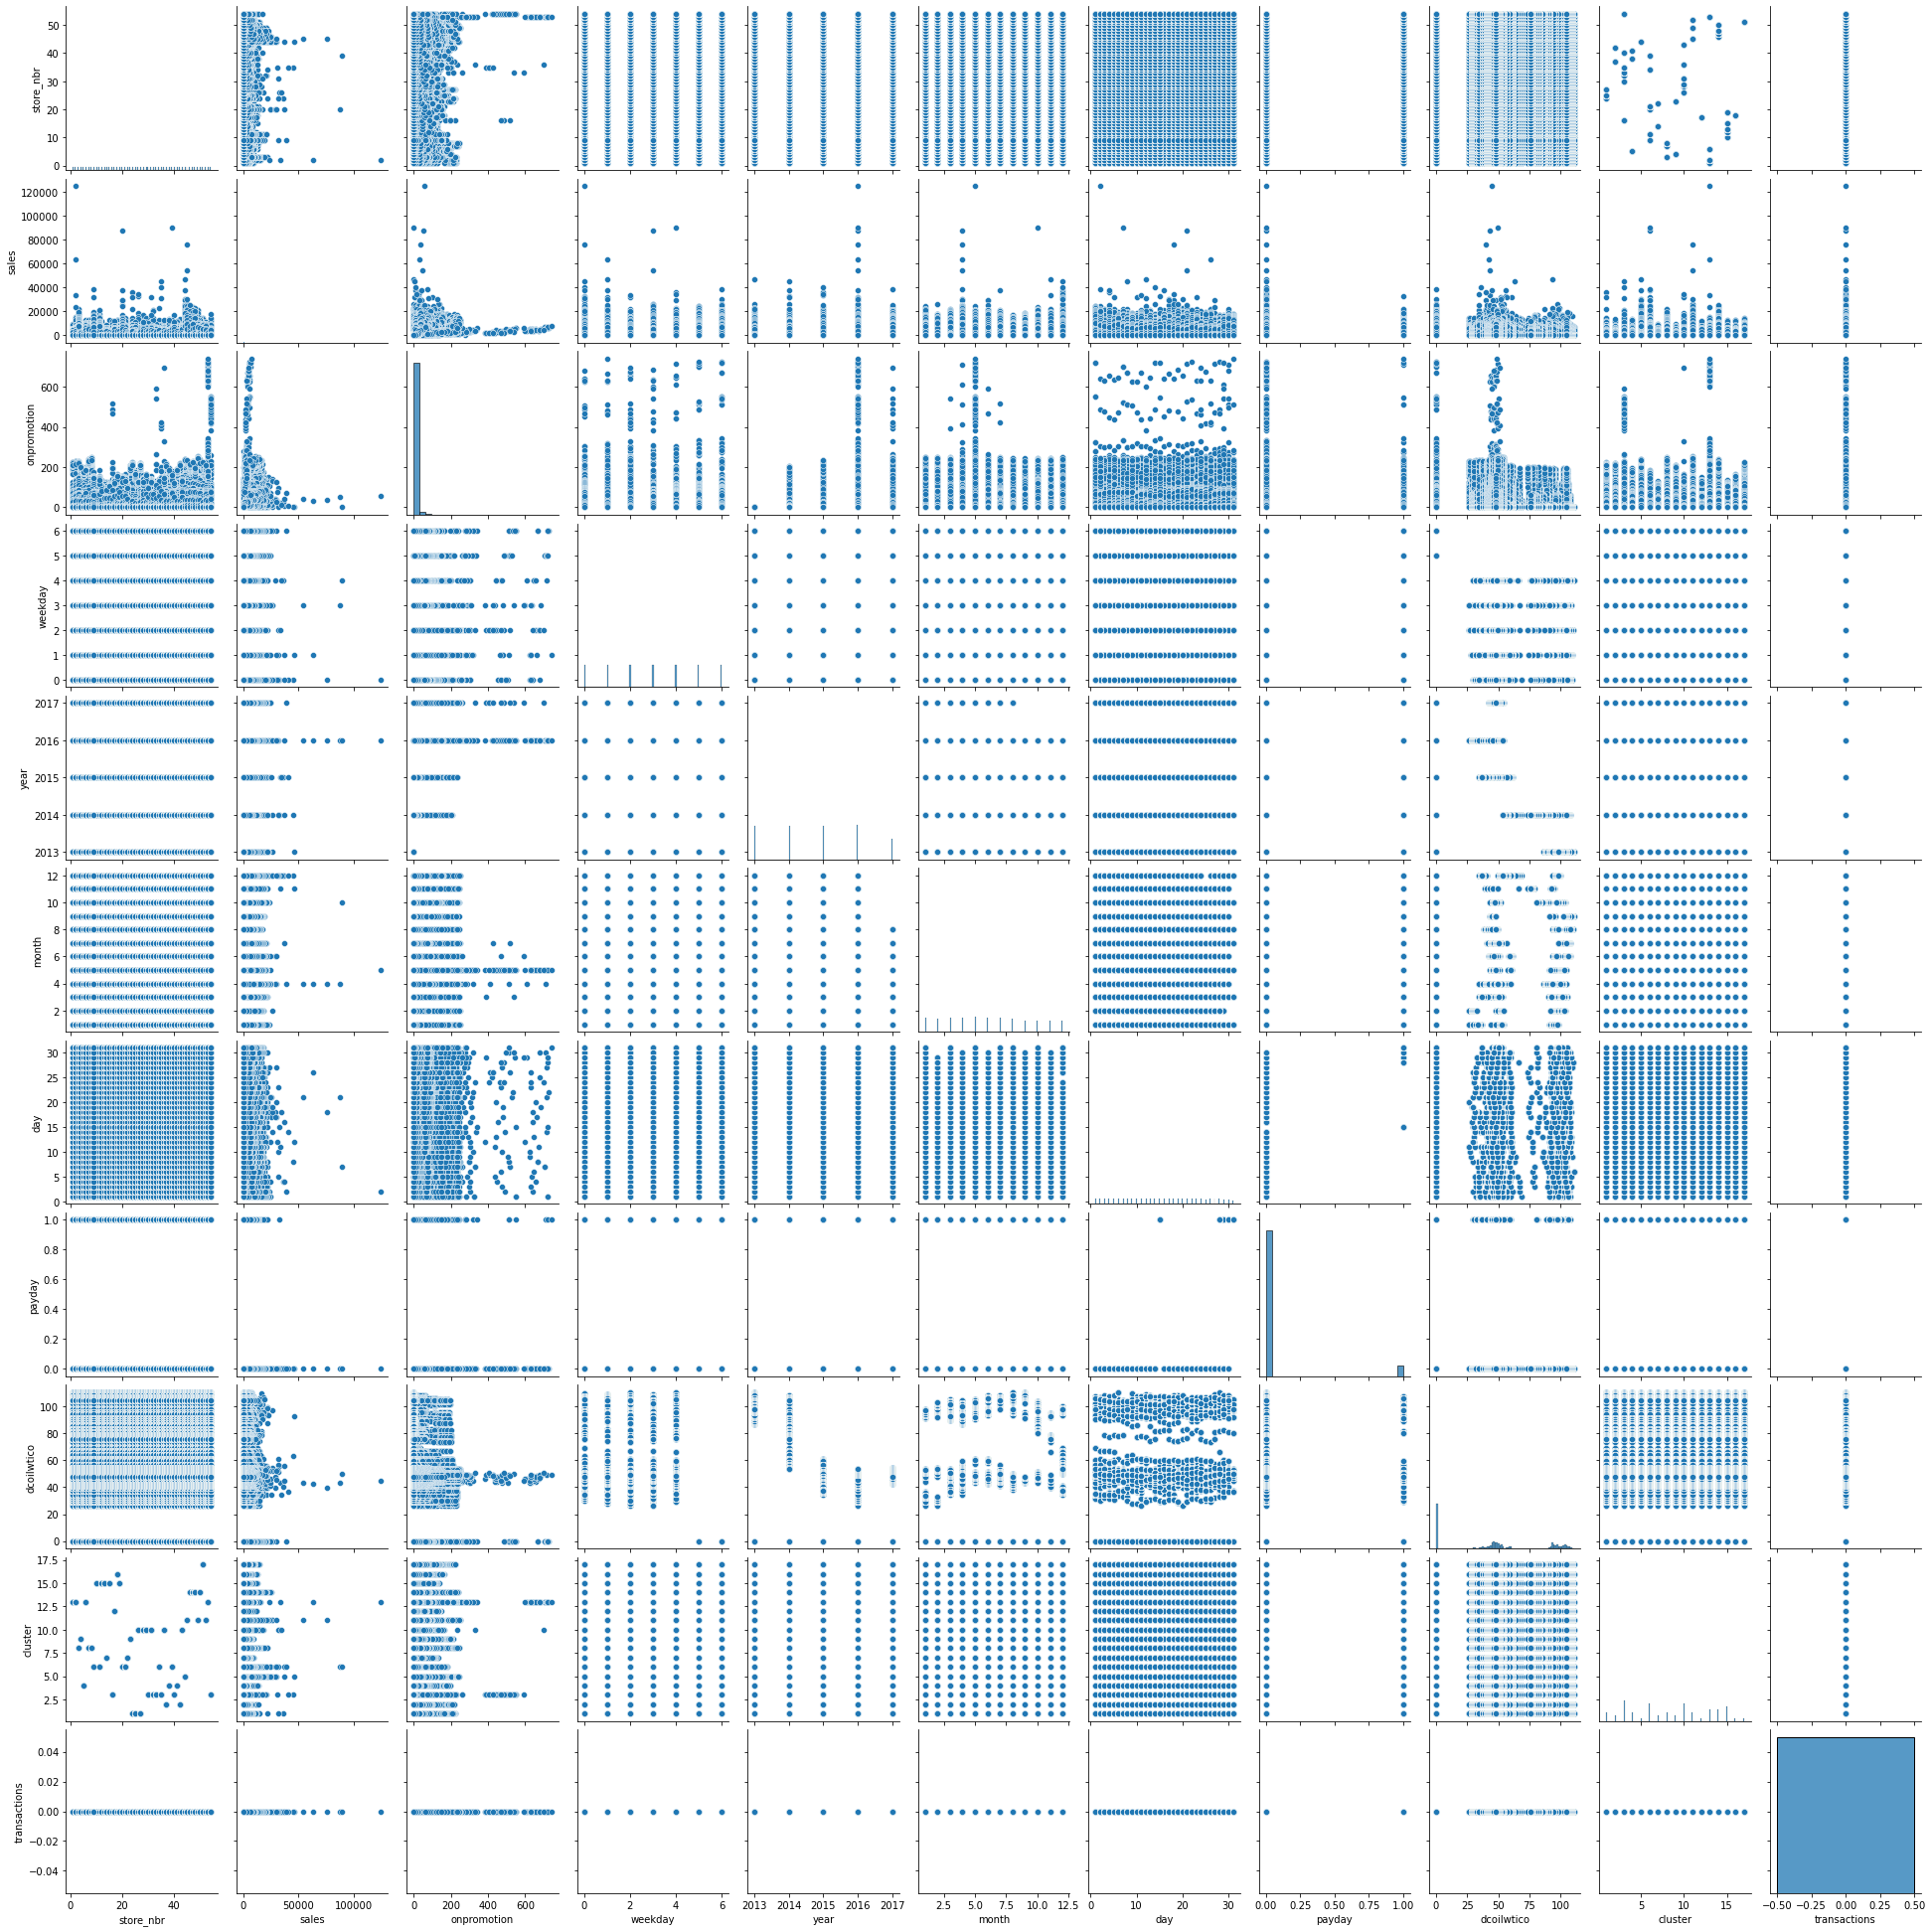

In [45]:
sns.pairplot(train)

<ipython-input-46-702460143a67>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  scatter_matrix(train, alpha=1, ax=ax)
/Users/atanughosh/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:89: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/atanughosh/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:90: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/atanughosh/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


array([[<AxesSubplot:xlabel='store_nbr', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='sales', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='onpromotion', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='weekday', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='year', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='month', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='day', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='payday', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='dcoilwtico', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='cluster', ylabel='store_nbr'>,
        <AxesSubplot:xlabel='transactions', ylabel='store_nbr'>],
       [<AxesSubplot:xlabel='store_nbr', ylabel='sales'>,
        <AxesSubplot:xlabel='sales', ylabel='sales'>,
        <AxesSubplot:xlabel='onpromotion', ylabel='sales'>,
        <AxesSubplot:xlabel='weekday', ylabel='sales'>,
        <AxesSubplot:xlabel='year', ylabel='sales'>,
        <AxesSubplot:xlabel='month', ylabel='sales'>,
  

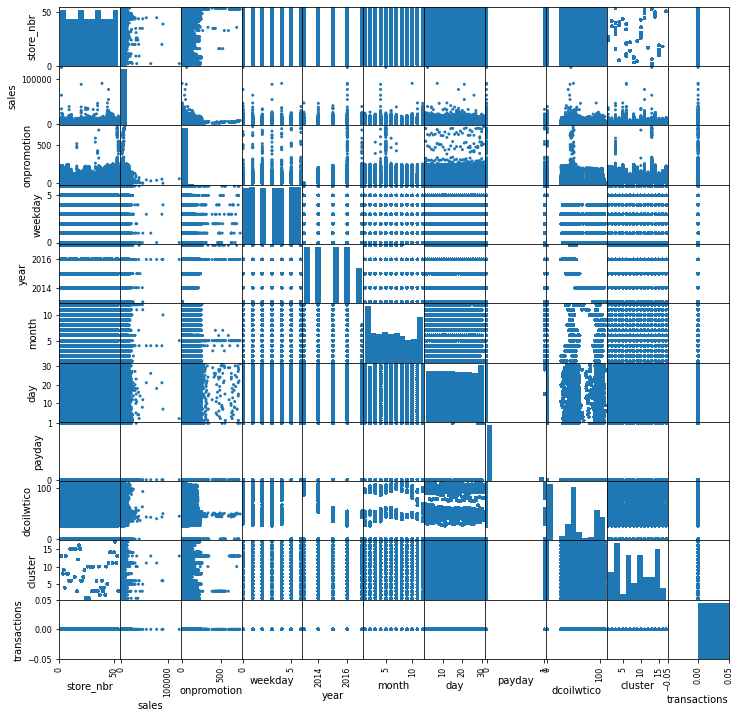

In [46]:
from pandas.plotting import scatter_matrix

fig, ax = plt.subplots(figsize=(12,12))
scatter_matrix(train, alpha=1, ax=ax)